In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_probability as tfp
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'tensorflow_probability'

In [2]:
import os

os.chdir('C:\\Users\\551338\\Documents\\HSPO\\repos\\time-series-analysis\\datasets\\IDES')
os.getcwd()

df = pd.read_csv('20200816_IDES_timeliness_data.csv', encoding= 'unicode_escape')
df.head()

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness
0,97451,ARMY,Active,ACTIVE,"Lewis JB, WA",2014-01-02,2014-01-02,Claim Development,0
1,98267,ARMY,Active,ACTIVE,"Walter Reed NMMC, MD",2014-01-02,2014-01-10,Claim Development,8
2,98527,ARMY,NaN,RESERVE,"Ft. Gordon, GA",2014-01-02,2014-01-03,Claim Development,1
3,100081,ARMY,Active,ACTIVE,"Ft. Gordon, GA",2014-01-02,2014-01-02,Claim Development,0
4,100710,ARMY,Active,ACTIVE,"Ft. Polk, LA",2014-01-02,2014-01-02,Claim Development,0


In [3]:
#nice function that lists files in the operating directory

for dirname, _, filenames in os.walk('C:\\Users\\551338\\Documents\\HSPO\\repos\\time-series-analysis\\datasets\\IDES'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

C:\Users\551338\Documents\HSPO\repos\time-series-analysis\datasets\IDES\20200809_IDES_timeliness.csv
C:\Users\551338\Documents\HSPO\repos\time-series-analysis\datasets\IDES\20200816_IDES_flows_data.csv
C:\Users\551338\Documents\HSPO\repos\time-series-analysis\datasets\IDES\20200816_IDES_timeliness_data.csv
C:\Users\551338\Documents\HSPO\repos\time-series-analysis\datasets\IDES\df2.csv
C:\Users\551338\Documents\HSPO\repos\time-series-analysis\datasets\IDES\df2_analysis.xlsx


Explore the space

In [4]:
print(df.isnull().any(), "\n", "\n", df.isnull().sum() )

case.id        False
service        False
duty.mod        True
component      False
meb.mtf.loc    False
start          False
end            False
Stage          False
timeliness     False
dtype: bool 
 
 case.id            0
service            0
duty.mod       25903
component          0
meb.mtf.loc        0
start              0
end                0
Stage              0
timeliness         0
dtype: int64


This is a handy loop to take care of NAN's and impute either and a different text value or numerical value.
#https://www.kaggle.com/lonnieqin/house-prices-prediction-with-catboost



In [5]:
for data in [df]:
    null_counts = data.isnull().sum()
    null_counts[null_counts > 0]
    null_columns = list(pd.DataFrame(null_counts[null_counts > 0]).index)
    for column in null_columns:
        if data[column].dtype == object:
            data[column] = data[[column]].replace(np.NAN, "Active") #why double brackets here??
        else:
            data[column] = data[column].replace(np.NAN, data[column].mean())

In [6]:
df['duty.mod'].unique()

array(['Active', 'NAD'], dtype=object)

In [7]:
#Getting unique counts


dict = {} #initialize dictionary
for col in list(df.columns): #for each column in a created list of the columns in df
    dict[col] = df[col].value_counts().shape[0]#hmmmmmmm. Need to understand reason for shape in here

pd.DataFrame(dict,index=["unique count"]).T

,unique count
case.id,206434
service,4
duty.mod,2
component,3
meb.mtf.loc,133
start,2418
end,2421
Stage,20
timeliness,972


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553592 entries, 0 to 2553591
Data columns (total 9 columns):
case.id        int64
service        object
duty.mod       object
component      object
meb.mtf.loc    object
start          object
end            object
Stage          object
timeliness     int64
dtypes: int64(2), object(7)
memory usage: 175.3+ MB


In [9]:
df[['service', 'duty.mod', 'component', 'meb.mtf.loc', 'Stage']] = df[['service', 'duty.mod', 'component', 'meb.mtf.loc', 'Stage']].astype(str)

df[['start','end']] = df[['start','end']].apply(pd.to_datetime)


In [10]:
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553592 entries, 0 to 2553591
Data columns (total 9 columns):
case.id        int64
service        object
duty.mod       object
component      object
meb.mtf.loc    object
start          datetime64[ns]
end            datetime64[ns]
Stage          object
timeliness     int64
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 175.3+ MB


case.id                 int64
service                object
duty.mod               object
component              object
meb.mtf.loc            object
start          datetime64[ns]
end            datetime64[ns]
Stage                  object
timeliness              int64
dtype: object

In [11]:
df['Stage'].unique()

array(['Claim Development', 'Elections', 'FPEB', 'FPEB Appeal',
       'Final Disposition', 'IDES Process', 'IPEB', 'MEB', 'MEB Appeals',
       'MEB Phase', 'PEB Phase', 'Parallel Track', 'Proposed Disposition',
       'Proposed Rating', 'Ref2Sep', 'Referral', 'Transition',
       'VA Benefits', 'VA Medical Evaluation',
       'VA Rating Reconsideration'], dtype=object)

In [12]:
df2 = df[df['service'] == 'ARMY']
df2 = df2[df2['Stage'] == 'MEB']
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109982 entries, 879004 to 1047983
Data columns (total 9 columns):
case.id        109982 non-null int64
service        109982 non-null object
duty.mod       109982 non-null object
component      109982 non-null object
meb.mtf.loc    109982 non-null object
start          109982 non-null datetime64[ns]
end            109982 non-null datetime64[ns]
Stage          109982 non-null object
timeliness     109982 non-null int64
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 8.4+ MB


In [13]:
df2.head()

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness
879004,60857,ARMY,Active,GUARD,"Ft. Benning, GA",2014-01-02,2014-01-13,MEB,11
879005,92360,ARMY,Active,GUARD,"Ft. Carson (MEBROC), CO",2014-01-02,2014-02-18,MEB,30
879006,94451,ARMY,Active,RESERVE,"Ft. Carson (MEBROC), CO",2014-01-02,2014-02-07,MEB,36
879007,95597,ARMY,Active,RESERVE,"Ft. Leonard Wood, MO",2014-01-02,2014-03-04,MEB,42
879008,95759,ARMY,Active,GUARD,"Ft. Gordon, GA",2014-01-02,2014-03-19,MEB,41


In [14]:
from datetime import datetime

In [15]:
df2['year'] = pd.DatetimeIndex(df2['end']).year
df2['week'] = pd.DatetimeIndex(df2['end']).week
df2['month'] = pd.DatetimeIndex(df2['end']).month
#print('Year: ', my_date.year) # To Get month from year

In [16]:
df2 = df2[df2['year'] >= 2017]

In [17]:
df2.sort_values(by=['end'])

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness,year,week,month
960206,182259,ARMY,Active,ACTIVE,"Ft. Leavenworth, KS",2016-11-09,2017-01-03,MEB,45,2017,1,1
960239,184206,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-11-09,2017-01-04,MEB,56,2017,1,1
959740,180898,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-11-03,2017-01-04,MEB,56,2017,1,1
959258,178045,ARMY,NAD,RESERVE,"Lewis JB, WA",2016-10-28,2017-01-04,MEB,68,2017,1,1
958332,182669,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-10-18,2017-01-04,MEB,69,2017,1,1
957964,179095,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-10-13,2017-01-04,MEB,76,2017,1,1
958753,181092,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-10-24,2017-01-04,MEB,47,2017,1,1
959732,170075,ARMY,NAD,RESERVE,"Ft. Gordon, GA",2016-11-03,2017-01-04,MEB,61,2017,1,1
959631,181033,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-11-02,2017-01-04,MEB,63,2017,1,1
958675,182672,ARMY,Active,ACTIVE,"Lewis JB, WA",2016-10-21,2017-01-04,MEB,68,2017,1,1


In [18]:
#Calculating a mean by week and by month
df2['weeklyavg'] = df2.groupby(['year','week'])['timeliness'].transform('mean')
df2['monthlyavg'] = df2.groupby(['year','month'])['timeliness'].transform('mean')

In [19]:
df2.head()

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness,year,week,month,weeklyavg,monthlyavg
930868,151259,ARMY,NAD,GUARD,"West Point, NY",2015-11-02,2017-05-23,MEB,549,2017,21,5,20.343750,19.108665
934378,158309,ARMY,Active,GUARD,"Ft. Gordon, GA",2015-12-14,2017-03-03,MEB,38,2017,9,3,25.167442,23.223664
935026,150590,ARMY,Active,GUARD,"San Antonio JB (Sam Houston), TX",2015-12-22,2017-03-22,MEB,447,2017,12,3,22.160550,23.223664
935653,188363,ARMY,Active,ACTIVE,"Ft. Bliss, TX",2016-01-03,2017-01-30,MEB,32,2017,5,1,37.423767,49.806509
940863,162801,ARMY,Active,ACTIVE,"Ft. Bragg, NC",2016-03-10,2017-01-27,MEB,76,2017,4,1,42.614719,49.806509


In [20]:
#Creating a marker for weekly average. This will allow us to remove the duplicates based on the 'yearweek' column
df2[['year', 'week', 'month']] = df2[['year', 'week', 'month']].astype(str) 
df2['yearweek'] = df2.year + df2.week
df2['yearmonth'] = df2.year + df2.month
df2.head()

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness,year,week,month,weeklyavg,monthlyavg,yearweek,yearmonth
930868,151259,ARMY,NAD,GUARD,"West Point, NY",2015-11-02,2017-05-23,MEB,549,2017,21,5,20.343750,19.108665,201721,20175
934378,158309,ARMY,Active,GUARD,"Ft. Gordon, GA",2015-12-14,2017-03-03,MEB,38,2017,9,3,25.167442,23.223664,20179,20173
935026,150590,ARMY,Active,GUARD,"San Antonio JB (Sam Houston), TX",2015-12-22,2017-03-22,MEB,447,2017,12,3,22.160550,23.223664,201712,20173
935653,188363,ARMY,Active,ACTIVE,"Ft. Bliss, TX",2016-01-03,2017-01-30,MEB,32,2017,5,1,37.423767,49.806509,20175,20171
940863,162801,ARMY,Active,ACTIVE,"Ft. Bragg, NC",2016-03-10,2017-01-27,MEB,76,2017,4,1,42.614719,49.806509,20174,20171


In [21]:
#Creating a separate dataframe to experiment with
df3 = df2
df3.head()

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness,year,week,month,weeklyavg,monthlyavg,yearweek,yearmonth
930868,151259,ARMY,NAD,GUARD,"West Point, NY",2015-11-02,2017-05-23,MEB,549,2017,21,5,20.343750,19.108665,201721,20175
934378,158309,ARMY,Active,GUARD,"Ft. Gordon, GA",2015-12-14,2017-03-03,MEB,38,2017,9,3,25.167442,23.223664,20179,20173
935026,150590,ARMY,Active,GUARD,"San Antonio JB (Sam Houston), TX",2015-12-22,2017-03-22,MEB,447,2017,12,3,22.160550,23.223664,201712,20173
935653,188363,ARMY,Active,ACTIVE,"Ft. Bliss, TX",2016-01-03,2017-01-30,MEB,32,2017,5,1,37.423767,49.806509,20175,20171
940863,162801,ARMY,Active,ACTIVE,"Ft. Bragg, NC",2016-03-10,2017-01-27,MEB,76,2017,4,1,42.614719,49.806509,20174,20171


In [22]:
#listing out the duplicates
df3["yearweek"].value_counts()

20174     1386
20178      723
20173      560
201710     519
20175      446
201712     436
20179      430
20171      413
201713     409
201715     402
201728     394
201823     389
20172      386
201714     383
201951     382
201815     382
201740     375
20202      374
201716     367
201742     367
201920     367
201825     367
201933     367
201724     365
201746     365
201737     361
202011     360
201818     357
20207      355
20177      354
          ... 
201836     237
20191      232
201846     230
201820     229
201841     217
20194      209
202018     209
201747     205
201847     193
201948     174
202033     170
201752     154
202032     150
202019     137
202031     126
201952     125
202020     109
201852     103
202030      95
202029      94
202021      78
20201       63
202027      51
202028      51
202023      47
202026      45
202024      41
202022      38
20176       36
202025      26
Name: yearweek, Length: 189, dtype: int64

In [23]:
#Dropping all those duplicates of "yearweek" or "yearmonth"
#df3.drop_duplicates(subset ="yearweek",
#                     keep = "first", inplace = True) #note that keep has to the "first", "last", or "False"

df3.drop_duplicates(subset ="yearmonth",
                     keep = "first", inplace = True) #note that keep has to the "first", "last", or "False"

In [24]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 930868 to 1027817
Data columns (total 16 columns):
case.id        44 non-null int64
service        44 non-null object
duty.mod       44 non-null object
component      44 non-null object
meb.mtf.loc    44 non-null object
start          44 non-null datetime64[ns]
end            44 non-null datetime64[ns]
Stage          44 non-null object
timeliness     44 non-null int64
year           44 non-null object
week           44 non-null object
month          44 non-null object
weeklyavg      44 non-null float64
monthlyavg     44 non-null float64
yearweek       44 non-null object
yearmonth      44 non-null object
dtypes: datetime64[ns](2), float64(2), int64(2), object(10)
memory usage: 5.8+ KB


In [25]:
df3.sort_values(by=['end'])

,case.id,service,duty.mod,component,meb.mtf.loc,start,end,Stage,timeliness,year,week,month,weeklyavg,monthlyavg,yearweek,yearmonth
935653,188363,ARMY,Active,ACTIVE,"Ft. Bliss, TX",2016-01-03,2017-01-30,MEB,32,2017,5,1,37.423767,49.806509,20175,20171
943188,165273,ARMY,Active,ACTIVE,"Ft. Bragg, NC",2016-04-08,2017-02-03,MEB,112,2017,5,2,37.423767,34.095210,20175,20172
934378,158309,ARMY,Active,GUARD,"Ft. Gordon, GA",2015-12-14,2017-03-03,MEB,38,2017,9,3,25.167442,23.223664,20179,20173
947467,170026,ARMY,Active,ACTIVE,"Tripler AMC, HI",2016-05-26,2017-04-25,MEB,131,2017,17,4,21.373887,20.957718,201717,20174
930868,151259,ARMY,NAD,GUARD,"West Point, NY",2015-11-02,2017-05-23,MEB,549,2017,21,5,20.343750,19.108665,201721,20175
949086,170042,ARMY,Active,ACTIVE,"Ft. Bragg, NC",2016-06-16,2017-06-21,MEB,40,2017,25,6,19.706052,18.612772,201725,20176
958302,182001,ARMY,Active,ACTIVE,"Ft. Gordon, GA",2016-10-18,2017-07-11,MEB,244,2017,28,7,21.170051,20.106522,201728,20177
949063,174771,ARMY,Active,ACTIVE,"Ft. Hood, TX",2016-06-15,2017-08-08,MEB,252,2017,32,8,20.567114,19.705314,201732,20178
956397,183279,ARMY,Active,ACTIVE,"Ft. Carson, CO",2016-09-20,2017-09-06,MEB,127,2017,36,9,20.162162,20.565421,201736,20179
953228,174580,ARMY,NAD,GUARD,"Camp Atterbury (MEBROC), IN",2016-08-10,2017-10-16,MEB,12,2017,42,10,21.474114,20.722678,201742,201710


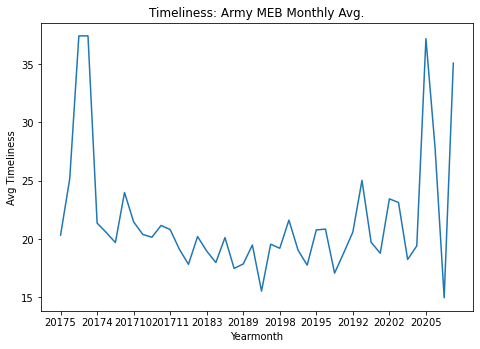

In [26]:
x = df3['yearmonth']
y = df3['weeklyavg']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(x,y)
ax.set_xlabel('Yearmonth')
ax.set_ylabel('Avg Timeliness')
ax.set_title('Timeliness: Army MEB Monthly Avg.')
ax.set_xticks(ax.get_xticks()[::4])# Fixes X axis density issue

In [ ]:
tsweekly = df2.groupby(['end'])['weeklyavg'].mean()
#df['avg_result'] = df.groupby(['a','b'])['result'].transform('mean')
tsweekly.reset_index()
tsweekly = pd.DataFrame(tsweekly)
#tsweekly.info()
tsweekly.head()

In [ ]:
x = tsweekly['end']
y = tsweekly['weeklyavg']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(x,y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title')

In [19]:
df2.to_csv('df2.csv', sep=';')